In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import shapefile as shp
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [10]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200       

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path     = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path     = None #'~/figures/test_papermill/'
save_fname    = None # filename from papermill come in through save_fname
tripyrun_name      = None # papermill workflow name of notebook 
tripyrun_analysis  = None # papermill diagnostic driver
tripyrun_spath_nb  = None # papermill path to processed notebooks
tripyrun_spath_fig = None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names   = list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None 
do_allcycl= True 
vname     = 'hflx'
year      = [1979,2019]
mon       = None
day       = None
record    = None 
box       = None
depth     = None

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Boxregion via shape file for index compuation______________________________
box_region = list()
box_region.append('global')
# box_region.append('moc_basins/Atlantic_MOC.shp')
# box_region.append('moc_basins/IndoPacific_MOC.shp')
# box_region.append('ocean_basins/Atlantic_Basin.shp')
# box_region.append('ocean_basins/Pacific_Basin.shp')

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 1      # number of pannel columns in figure
nrow              = 1
plt_opt           = dict({'marker':'o'})
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
save_dpi          = 300
save_fmt          = ['png']
use_advflx        = True  # True: compute hflux from u*t and v*t, False: compute hflx from u, v, temp,+(u_bolus, v_bolus)
use_bolusv        = True  # True: include bolus velocity
do_edgevec_r2g    = False

# these parameters are not needed here but need to be defined for papermill 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None

In [11]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

 --> memory_limit: 2.778 GB


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/distributed/node.py:169: ResourceWarning: unclosed <socket.socket fd=67, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 0)>
  raise
/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39559 instead
  warnings.warn(


In [12]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True)

#______________________________________________________________________________________________________
if n_cycl is not None:
    cycl_s = n_cycl
    if do_allcycl: cycl_s=1
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name

    if (ref_path is not None): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)   
    
#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names
        
#______________________________________________________________________________________________________
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region == 'global' or isinstance(region,list): box.append(region)
    else: box.append(shp.Reader(os.path.join(shp_path,region)))        

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 'auto', 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : 'auto', 
               'nz'   : 'auto',
               'edg_n': 'auto'})

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [13]:
ts = clock.time()
datapath = input_paths[0]
#___________________________________________________________________________
# load information about edges 
fname = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

#___________________________________________________________________________
# set specfic type when loading --> #convert to specific precision
# drop unnecessary variables:  Based on the documentation (but a bit hidden), 
# the "data_vars=" argument only works with Python 3.9.
from functools import partial
var_keep = ['edges', 'edge_tri', 'edge_cross_dxdy']
def _preprocess(x):
    for var in list(x.keys()):
        if var not in var_keep: 
            x = x.drop_vars(var)
            continue
        if x[var].dtype=='float64': x[var] = x[var].astype('float32')
    return x
partial_func = partial(_preprocess)

#___________________________________________________________________________
# load diag file --> apply drop variables by preprocessor function
mdiag = xr.open_mfdataset(os.path.join(dname,fname), parallel=False, 
                             chunks=dict({'edg_n':'auto'}), engine='netcdf4', 
                             preprocess=partial_func)
mdiag = mdiag.drop_vars(list(mdiag.coords)).unify_chunks()

# node indices of edge points [2 x n2ded]--> indices in python start with 0
mdiag['edges']    = mdiag['edges']-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
# --> indices in python start with 0
mdiag['edge_tri'] = mdiag['edge_tri']-1

# Suppress the specific warning about sending large graphs
warnings.filterwarnings("ignore", category=UserWarning, message="Sending large graph of size")

#___________________________________________________________________________
# add edge coordinates and edge mid point coordinates
set_mdiag_chunk = dict({'edg_n': mdiag.chunksizes['edg_n']})
mdiag = mdiag.assign(edge_x = xr.DataArray(mesh.n_x[mdiag.edges], dims=['n2','edg_n']).astype('float32').chunk(set_mdiag_chunk))
mdiag = mdiag.assign(edge_y = xr.DataArray(mesh.n_y[mdiag.edges], dims=['n2','edg_n']).astype('float32').chunk(set_mdiag_chunk))
# mdiag = mdiag.drop_vars('edges')

mdiag = mdiag.assign(edge_mx = mdiag.edge_x.sum(dim='n2')/2.0)
mdiag = mdiag.assign(edge_my = mdiag.edge_y.sum(dim='n2')/2.0)

#___________________________________________________________________________
# Be sure that the edge_cross_dxdy variable is in the same rotational frame as your velocities. By default
# edge_cross_dxdy is in rotated coordinates. So if you velocities are also in rotated coordinates things are fine.
# If your velocities should be in geo coordinates than edge_cross_dxdy needs to be rotated as well into geo
# coordinates (do_edgevec_r2g=True)
if (do_edgevec_r2g):
    mdiag.edge_cross_dxdy[0,:], mdiag.edge_cross_dxdy[1,:] = tpv.vec_r2g(mesh.abg, mdiag.edge_mx, mdiag.edge_my, 
                                                                         mdiag.edge_cross_dxdy[0,:], mdiag.edge_cross_dxdy[1,:], 
                                                                         gridis='geo', do_info=False )
    mdiag.edge_cross_dxdy[2,:], mdiag.edge_cross_dxdy[3,:] = tpv.vec_r2g(mesh.abg, mdiag.edge_mx, mdiag.edge_my, 
                                                                         mdiag.edge_cross_dxdy[2,:], mdiag.edge_cross_dxdy[3,:], 
                                                                         gridis='geo', do_info=False )

#___________________________________________________________________________
set_mdiag_chunk = dict({'edg_n': mdiag.chunksizes['edg_n'], 'n2':mdiag.chunksizes['n2']})
# dx & dy of left triangle --> cross-edge vector 
mdiag = mdiag.assign(edge_dxdy_l=xr.DataArray( np.array([ mdiag.edge_cross_dxdy[0,:], 
                                                          mdiag.edge_cross_dxdy[1,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))
# dx & dy of right triangle --> cross-edge vector 
mdiag = mdiag.assign(edge_dxdy_r=xr.DataArray( np.array([ mdiag.edge_cross_dxdy[2,:], 
                                                          mdiag.edge_cross_dxdy[3,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))

# if boundarie edge --> right triangle doesnot exist --> therefor dx,dy is zero there
idx = mdiag.edge_tri[1,:]<0
mdiag.edge_dxdy_r[:, idx.load()]=0. 
# mdiag.edge_dxdy_r[:, mdiag.edge_tri[1,:]<0]=0. 

#___________________________________________________________________________
# restructure edge_dxdy_l & edge_dxdy_r into edge_dx_lr0 & edge_dx_lr1
mdiag = mdiag.assign(edge_dx_lr=xr.DataArray( np.array([ mdiag.edge_dxdy_l[0,:], 
                                                         mdiag.edge_dxdy_r[0,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))
# dx & dy of right triangle --> norm vector 
mdiag = mdiag.assign(edge_dy_lr=xr.DataArray( np.array([ mdiag.edge_dxdy_l[1,:], 
                                                         mdiag.edge_dxdy_r[1,:]]), dims=['n2', 'edg_n']).chunk(set_mdiag_chunk))

#___________________________________________________________________________
# now drop edge_cross_dxdy variable dont need anymore
mdiag = mdiag.drop_vars(['edge_cross_dxdy', 'edge_dxdy_l', 'edge_dxdy_r', 'edge_y', 'edge_my', 'edge_mx']) #
mdiag = mdiag.load()

#___________________________________________________________________________
warnings.resetwarnings()
print(mdiag)
print(' --> elasped time: {} min.'.format( (clock.time()-ts)/60  ))
print(' --> mdiag uses {:3.2f} Gb:'.format(mdiag.nbytes/(1024**3)))

<xarray.Dataset>
Dimensions:     (n2: 2, edg_n: 371644)
Dimensions without coordinates: n2, edg_n
Data variables:
    edges       (n2, edg_n) int32 0 0 0 1 1 ... 126830 126832 126856 126857
    edge_tri    (n2, edg_n) int32 0 3 1 2 6 5 4 7 6 ... -1 -1 -1 -1 -1 -1 -1 -1
    edge_x      (n2, edg_n) float32 -179.7 -179.7 -179.7 ... 175.3 178.5 179.4
    edge_dx_lr  (n2, edg_n) float32 5.209e+03 867.5 -8.242e+03 ... 0.0 0.0 0.0
    edge_dy_lr  (n2, edg_n) float32 -2.484e+03 -7.361e+03 -4.272e+03 ... 0.0 0.0
 --> elasped time: 0.04526890913645427 min.
 --> mdiag uses 0.01 Gb:


In [14]:
#___LOAD FESOM2 DATA___________________________________________________________________________________
# load t*u and t*v together
data_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    ts = clock.time()
    if use_advflx:
        #__________________________________________________________________________________________________
        data = tpv.load_data_fesom2(mesh, datapath, vname='vec+tu+tv', year=year, descript=descript, 
                                    do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False,
                                    chunks=chunks, do_compute=False, do_load=True, do_persist=False, )
        datat= None
        
        #__________________________________________________________________________________________________    
        # check if data where loaded
        if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
        
    else:
        #__________________________________________________________________________________________________
        # load velocities
        data = tpv.load_data_fesom2(mesh, datapath, vname='vec+u+v', year=year, descript=descript, 
                                    do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False, chunks=chunks, 
                                    do_compute=False, do_load=True, do_persist=False, )
        
        #__________________________________________________________________________________________________    
        # check if data where loaded
        if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
        #__________________________________________________________________________________________________    
        if use_bolusv:
            data['u'].data = data['u'].data + tpv.load_data_fesom2(mesh, datapath, vname='bolus_u', year=year, descript=descript, 
                                                                   do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False,
                                                                   chunks=chunks, do_compute=False, do_load=True, do_persist=False)['bolus_u'].data
            data['v'].data = data['v'].data + tpv.load_data_fesom2(mesh, datapath, vname='bolus_v', year=year, descript=descript, 
                                                                   do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False,
                                                                   chunks=chunks, do_compute=False, do_load=True, do_persist=False)['bolus_v'].data
        
        #__________________________________________________________________________________________________
        # load temperature
        datat = tpv.load_data_fesom2(mesh, datapath, vname='temp', year=year, descript=descript, 
                                     do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False,
                                     chunks=chunks, do_compute=False, do_load=True, do_persist=False)
        
    # kick everything out that is not needed anymore,
    data = data.drop_vars(['lon', 'lat', 'elemi', 'elemiz', 'w_A', 'nz1',])
    if datat is not None: datat = datat.drop_vars(['lon', 'lat', 'nodi', 'nodiz', 'w_A', 'nz1',])
        
    # add vertical layer thickness as coordinate 
    data  = data.assign_coords(dz = xr.DataArray(np.diff(-mesh.zlev).astype('float32'), dims='nz1'))
        
    #__________________________________________________________________________________________________
    print(' --> elapsed time to load, prepare u,v, temp data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data_uv uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    if datat is not None: print(' --> data_t  uses {:3.2f} Gb:'.format(datat.nbytes/(1024**3)))
    print(' --> mdiag   uses {:3.2f} Gb:'.format(mdiag.nbytes/(1024**3)))
    
    #__________________________________________________________________________________________________
    # compute meridional heat flux from t*v by binning
    ts = clock.time()
    data_list.append(tpv.calc_zhflx_box_fast_lessmem(mesh, data, datat, mdiag, box, dlon=1.0, do_parallel=do_parallel, n_workers=parallel_nprc_bin, do_info=False))
    print(' --> elapsed time to comp. zonal. hflux: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    del(data)

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elapsed time to load, prepare u,v, temp data: 0.06 min.
 --> data_uv uses 0.09 Gb:
 --> mdiag   uses 0.01 Gb:
 --> elapsed time to comp. zonal. hflux: 0.07 min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elapsed time to load, prepare u,v, temp data: 0.06 min.
 --> data_uv uses 0.09 Gb:
 --> mdiag   uses 0.01 Gb:
 --> elapsed time to comp. zonal. hflux: 0.02 min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elapsed time to load, prepare u,v, temp data: 0.06 min.
 --> data_uv uses 0.09 Gb:
 --> mdiag   uses 0.01 Gb:
 --> elapsed time to comp. zonal. hflux: 0.02 min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elapsed time to load, prepare u,v, temp data: 0.06 min.
 --> data_uv uses 0.0

1 1


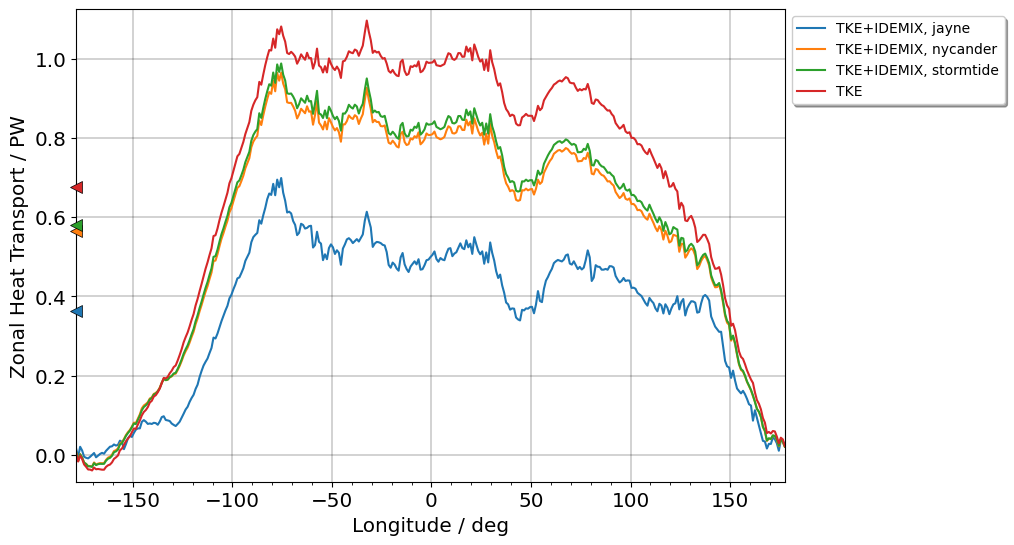

In [15]:
nbox = len(box)
if   ncol != None: 
    ncol0  = np.min([ncol,nbox])    
    nrow0  = np.ceil(nbox/ncol0).astype('int')
    if nrow != None: nrow0=nrow 
elif nrow != None: 
    nrow0  = np.min([nrow,nbox])    
    ncol0  = np.ceil(nbox/nrow0).astype('int') 
svname = list(data_list[0][0].data_vars)[0]
slabel = data_list[0][0][svname].attrs['str_lsave']
sbox   = data_list[0][0][svname].attrs['boxname'].replace(' ','_').lower()
print(nrow0, ncol0)
#__________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}.{:s}'.format(svname, 'hline' ,slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#__________________________________________________________________________________________________
hfig, hax = tpv.plot_hline(data_list           , 
                    box        = box           , 
                    box_idx    = None          ,
                    boxl_opt   = dict()        , # option for box label string 
                    nrow       = nrow0         , # number of row in figures panel
                    ncol       = ncol0         ,
                    ax_opt=dict({'fig_sizefac':3,}),
                    do_allcycl = do_allcycl    ,   
                    n_cycl     = n_cycl        ,
                    do_enum    = do_enum       ,
                    do_shdw    = do_shdw       ,
                    do_mean    = do_mean       ,
                    do_save    = sfpath, save_dpi=save_dpi  )

In [16]:
if do_papermill and do_parallel and client_runs:
    client.shutdown()
    client_runs = False